In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                # stopwords are removed from text to keep just useful info
from nltk import word_tokenize, sent_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

C:\Users\johns\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\johns\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\johns\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\johns\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [3]:
df = pd.read_csv('train.csv', encoding='latin1')

In [5]:
df['sentiment'] = df['sentiment'].replace({'negative':0, 'positive' : 1})


0        0
1        0
2        0
3        0
4        0
        ..
29995    1
29996    1
29997    1
29998    1
29999    1
Name: sentiment, Length: 30000, dtype: int64

In [6]:
y = df['sentiment']

In [7]:
X = df.drop(['sentiment'], axis=1)


,review
0,I should have never watched this movie. The st...
1,Robert Lansing plays a scientist experimenting...
2,I was looking forward to this movie. Trustwort...
3,Where to start? Some guy has some Indian pot t...
4,What happened? What we have here is basically ...
...,...
29995,I saw UZUMAKI about a year ago and was mesmeri...
29996,The Sentinel i was hoping would be a good film...
29997,"the Blues are really about, what would it look..."
29998,"I really liked this movie, it totally reminds ..."


In [15]:
import string

review_lines = list()
lines = X.values.tolist()



'["I should have never watched this movie. The style of filming may be considered artsy to some, but it is considered migraine-inducing to me. I think it may have had an interesting plot, but since I couldn\'t watch it for long stretches at a time I missed a lot. The flickering pictures and stop motion filming branded my brain. I stopped watching mid way through and won\'t be back for a second try. I suppose if I were home alone in my own lighthouse some dark and stormy evening, this might be just the ticket... PS Not sure if the lighthouse/ film style thing can be considered a spoiler, but I don\'t want to be blacklisted on my first review ;)"]'

In [16]:
for line in lines:
    
    '''
    breaks line into it's sub parts like each word and comma etc,
    https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
    '''
    line = str(line)
    tokens = word_tokenize(line)   
    
     #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
    table = str.maketrans('','', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
     
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    
    review_lines.append(words)

In [20]:
import gensim

embedding_vector_size = 150
# now training embeddings for each word 
model_1 = gensim.models.Word2Vec(sentences = review_lines, size=embedding_vector_size, min_count=1, window=5, workers=4 )

# to get total number of unique words
words = list(model_1.wv.vocab)

print("vocab size:", len(words))

vocab size: 93079


Text(0, 0.5, 'frequency')

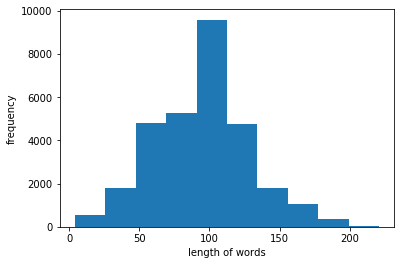

In [21]:
leng=0
length = [(leng + len(x)) for x in review_lines]
plt.hist(length)
plt.xlabel('length of review')
plt.ylabel('frequency')

In [22]:
import math
avg_length = sum(length)/len(review_lines)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)


94.9999


In [24]:
max_len = math.ceil(avg_length) 

95

In [48]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = 120)

In [49]:
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [50]:
X = train_test_data

In [53]:
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = 120, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))



model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 150)          13962000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 14,073,381
Trainable params: 14,073,381
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
history = model.fit(X_train, y_train, epochs = 15, validation_data=[X_test, y_test])


Train on 24000 samples, validate on 6000 samples
Epoch 1/15
24000/24000 [==============================] - 282s 12ms/sample - loss: 0.1053 - acc: 0.9631 - val_loss: 0.3892 - val_acc: 0.8822
Epoch 2/15
24000/24000 [==============================] - 267s 11ms/sample - loss: 0.0905 - acc: 0.9687 - val_loss: 0.4428 - val_acc: 0.8785
Epoch 3/15
24000/24000 [==============================] - 268s 11ms/sample - loss: 0.0799 - acc: 0.9742 - val_loss: 0.4701 - val_acc: 0.8762
Epoch 4/15
24000/24000 [==============================] - 398s 17ms/sample - loss: 0.0676 - acc: 0.9770 - val_loss: 0.5215 - val_acc: 0.8700
Epoch 5/15
24000/24000 [==============================] - 443s 18ms/sample - loss: 0.0564 - acc: 0.9812 - val_loss: 0.5970 - val_acc: 0.8748
Epoch 6/15
24000/24000 [==============================] - 423s 18ms/sample - loss: 0.0480 - acc: 0.9839 - val_loss: 0.6541 - val_acc: 0.8722
Epoch 7/15
24000/24000 [==============================] - 444s 18ms/sample - loss: 0.0385 - acc: 0.9868 -

In [65]:
max_length_list = [90, 100, 110, 120, 130, 140, 150]


In [72]:
def test_max_length(max_list):
    hist_list = list()
    for ml in max_list:
        max_features = 10000
        tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
        train_test_data = review_lines                       # contains word tokens extracted from lines
        tokenizer.fit_on_texts(train_test_data)
        sequence = tokenizer.texts_to_sequences(train_test_data)
        train_test_data = pad_sequences(sequence, maxlen = ml)
        
        
        vocab_size = len(tokenizer.word_index)+1
        embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
        # +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
        for  word, i in tokenizer.word_index.items():
            embedding_vector = model_1.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        
        X = train_test_data
        
        tf.keras.backend.clear_session()  # For easy reset of notebook state.
        config_proto = tf.ConfigProto()
        off = rewriter_config_pb2.RewriterConfig.OFF
        config_proto.graph_options.rewrite_options.arithmetic_optimization = off
        session = tf.Session(config=config_proto)
        set_session(session)
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        model = Sequential()

        model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                            input_length = ml, weights = [embedding_matrix]))
        model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
        model.add(Dense(10))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs = 10, validation_data=[X_test, y_test])
        hist_list.append(history)
    return hist_list

        
        

In [71]:
hist_list = test_max_length(max_length_list)

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 215s 9ms/sample - loss: 0.4804 - acc: 0.7725 - val_loss: 0.4010 - val_acc: 0.8273
Epoch 2/10
24000/24000 [==============================] - 220s 9ms/sample - loss: 0.3542 - acc: 0.8518 - val_loss: 0.3265 - val_acc: 0.8587
Epoch 3/10
24000/24000 [==============================] - 219s 9ms/sample - loss: 0.2899 - acc: 0.8815 - val_loss: 0.3305 - val_acc: 0.8693
Epoch 4/10
24000/24000 [==============================] - 221s 9ms/sample - loss: 0.2508 - acc: 0.9011 - val_loss: 0.3832 - val_acc: 0.8702
Epoch 5/10
24000/24000 [==============================] - 222s 9ms/sample - loss: 0.2202 - acc: 0.9171 - val_loss: 0.3253 - val_acc: 0.8717
Epoch 6/10
24000/24000 [==============================] - 224s 9ms/sample - loss: 0.1946 - acc: 0.9265 - val_loss: 0.3584 - val_acc: 0.8692
Epoch 7/10
24000/24000 [==============================] - 226s 9ms/sample - loss: 0.1784 - acc: 0.9352 - val_lo

24000/24000 [==============================] - 295s 12ms/sample - loss: 0.1759 - acc: 0.9344 - val_loss: 0.3132 - val_acc: 0.8768
Epoch 8/10
24000/24000 [==============================] - 330s 14ms/sample - loss: 0.1596 - acc: 0.9415 - val_loss: 0.3779 - val_acc: 0.8752
Epoch 9/10
24000/24000 [==============================] - 306s 13ms/sample - loss: 0.1439 - acc: 0.9479 - val_loss: 0.3691 - val_acc: 0.8768
Epoch 10/10
24000/24000 [==============================] - 303s 13ms/sample - loss: 0.1234 - acc: 0.9574 - val_loss: 0.3906 - val_acc: 0.8663
Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 324s 14ms/sample - loss: 0.4882 - acc: 0.7683 - val_loss: 0.3903 - val_acc: 0.8330
Epoch 2/10
24000/24000 [==============================] - 310s 13ms/sample - loss: 0.3566 - acc: 0.8495 - val_loss: 0.3192 - val_acc: 0.8620
Epoch 3/10
24000/24000 [==============================] - 334s 14ms/sample - loss: 0.2953 - acc: 0.8817 - val_loss:

NameError: name 'history_list' is not defined

In [78]:
def test_max_features(max_list):
    hist_list = list()
   
    for mf in max_list:
        max_features = mf
        tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
        train_test_data = review_lines                       # contains word tokens extracted from lines
        tokenizer.fit_on_texts(train_test_data)
        sequence = tokenizer.texts_to_sequences(train_test_data)
        train_test_data = pad_sequences(sequence, maxlen = 120)
        
        X = train_test_data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        
        vocab_size = len(tokenizer.word_index)+1
        embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
        # +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
        for  word, i in tokenizer.word_index.items():
            embedding_vector = model_1.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        
        tf.keras.backend.clear_session()  # For easy reset of notebook state.
        config_proto = tf.ConfigProto()
        off = rewriter_config_pb2.RewriterConfig.OFF
        config_proto.graph_options.rewrite_options.arithmetic_optimization = off
        session = tf.Session(config=config_proto)
        set_session(session)
        
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                            input_length = 120, weights = [embedding_matrix]))
        model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
        model.add(Dense(10))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs = 10, validation_data=[X_test, y_test])
        hist_list.append(history)
    return hist_list


In [79]:
max_features_list = [5000,6000,8000,10000,12000,15000,17500,20000,25000,40000,50000]

In [80]:
hist_list = test_max_features(max_features_list)

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 292s 12ms/sample - loss: 0.4901 - acc: 0.7705 - val_loss: 0.3618 - val_acc: 0.8373
Epoch 2/10
24000/24000 [==============================] - 288s 12ms/sample - loss: 0.3720 - acc: 0.8425 - val_loss: 0.3247 - val_acc: 0.8580
Epoch 3/10
24000/24000 [==============================] - 295s 12ms/sample - loss: 0.3202 - acc: 0.8679 - val_loss: 0.3070 - val_acc: 0.8737
Epoch 4/10
24000/24000 [==============================] - 294s 12ms/sample - loss: 0.2821 - acc: 0.8861 - val_loss: 0.2950 - val_acc: 0.8793
Epoch 5/10
24000/24000 [==============================] - 288s 12ms/sample - loss: 0.2646 - acc: 0.8963 - val_loss: 0.3078 - val_acc: 0.8795
Epoch 6/10
24000/24000 [==============================] - 427s 18ms/sample - loss: 0.2437 - acc: 0.9050 - val_loss: 0.2980 - val_acc: 0.8775
Epoch 7/10
24000/24000 [==============================] - 490s 20ms/sample - loss: 0.2255 - acc: 0.9139 -

Epoch 7/10
24000/24000 [==============================] - 258s 11ms/sample - loss: 0.1493 - acc: 0.9456 - val_loss: 0.3730 - val_acc: 0.8768
Epoch 8/10
24000/24000 [==============================] - 259s 11ms/sample - loss: 0.1323 - acc: 0.9548 - val_loss: 0.3491 - val_acc: 0.8765
Epoch 9/10
24000/24000 [==============================] - 263s 11ms/sample - loss: 0.1143 - acc: 0.9625 - val_loss: 0.4193 - val_acc: 0.8760
Epoch 10/10
24000/24000 [==============================] - 259s 11ms/sample - loss: 0.0964 - acc: 0.9668 - val_loss: 0.4285 - val_acc: 0.8712
Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 264s 11ms/sample - loss: 0.4857 - acc: 0.7697 - val_loss: 0.3662 - val_acc: 0.8495
Epoch 2/10
24000/24000 [==============================] - 265s 11ms/sample - loss: 0.3442 - acc: 0.8563 - val_loss: 0.3051 - val_acc: 0.8700
Epoch 3/10
24000/24000 [==============================] - 260s 11ms/sample - loss: 0.2661 - acc: 0.8973 

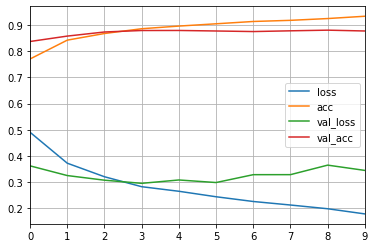

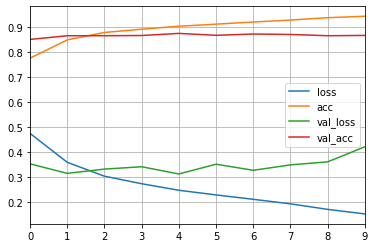

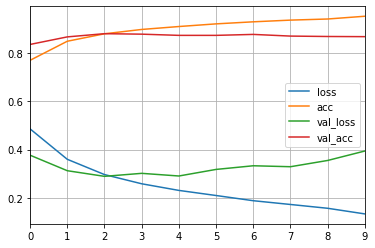

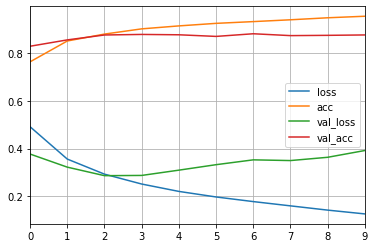

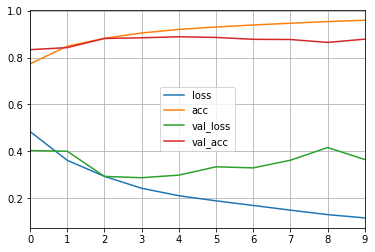

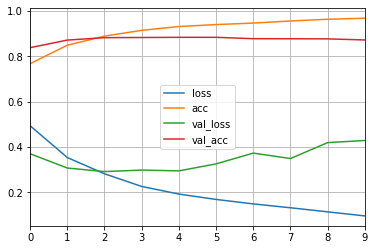

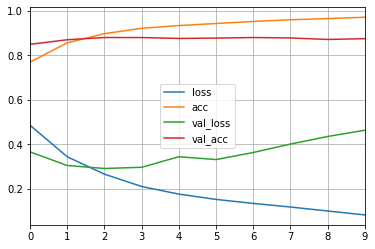

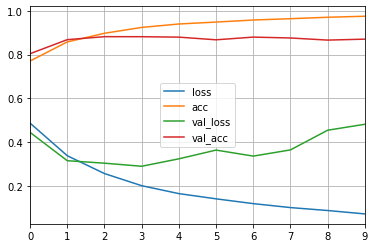

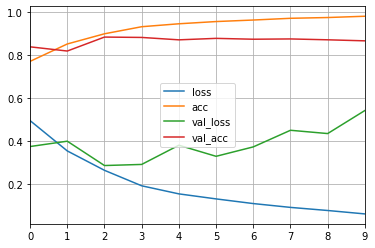

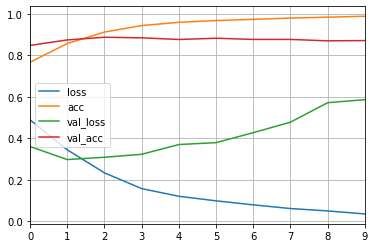

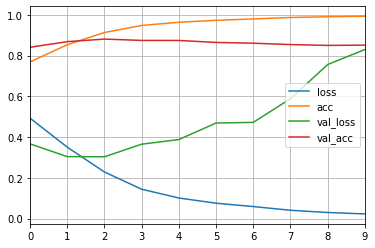

In [81]:
for hist in hist_list:
    pd.DataFrame(hist.history).plot()
    plt.grid(True)
    plt.show()

In [87]:
def test_ltsm_neurons(n_list):
    hist_list = list()
   
    max_features = 12000
    tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
    train_test_data = review_lines                       # contains word tokens extracted from lines
    tokenizer.fit_on_texts(train_test_data)
    sequence = tokenizer.texts_to_sequences(train_test_data)
    train_test_data = pad_sequences(sequence, maxlen = 120) 
    X = train_test_data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
    vocab_size = len(tokenizer.word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    for  word, i in tokenizer.word_index.items():
        embedding_vector = model_1.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    for n in n_list:
        
        tf.keras.backend.clear_session()  # For easy reset of notebook state.
        config_proto = tf.ConfigProto()
        off = rewriter_config_pb2.RewriterConfig.OFF
        config_proto.graph_options.rewrite_options.arithmetic_optimization = off
        session = tf.Session(config=config_proto)
        set_session(session)
        
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                            input_length = 120, weights = [embedding_matrix]))
        model.add(Bidirectional(LSTM(n, dropout=0.25, recurrent_dropout=0.1)))
        model.add(Dense(10))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs = 10, validation_data=[X_test, y_test])
        hist_list.append(history)
    return hist_list

In [88]:
n_list = [20,32,64,128,256]
hist_2 = test_ltsm_neurons(n_list)

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 185s 8ms/sample - loss: 0.5227 - acc: 0.7431 - val_loss: 0.3976 - val_acc: 0.8215
Epoch 2/10
24000/24000 [==============================] - 184s 8ms/sample - loss: 0.3769 - acc: 0.8433 - val_loss: 0.4089 - val_acc: 0.8260
Epoch 3/10
24000/24000 [==============================] - 184s 8ms/sample - loss: 0.3049 - acc: 0.8788 - val_loss: 0.3109 - val_acc: 0.8690
Epoch 4/10
24000/24000 [==============================] - 191s 8ms/sample - loss: 0.2501 - acc: 0.9036 - val_loss: 0.2946 - val_acc: 0.8733
Epoch 5/10
24000/24000 [==============================] - 189s 8ms/sample - loss: 0.2243 - acc: 0.9159 - val_loss: 0.3115 - val_acc: 0.8778
Epoch 6/10
24000/24000 [==============================] - 187s 8ms/sample - loss: 0.2028 - acc: 0.9267 - val_loss: 0.3191 - val_acc: 0.8802
Epoch 7/10
24000/24000 [==============================] - 188s 8ms/sample - loss: 0.1843 - acc: 0.9327 - val_lo

In [92]:
def test_ltsm_dropout(d_list):
    hist_list = list()
   
    max_features = 12000
    tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
    train_test_data = review_lines                       # contains word tokens extracted from lines
    tokenizer.fit_on_texts(train_test_data)
    sequence = tokenizer.texts_to_sequences(train_test_data)
    train_test_data = pad_sequences(sequence, maxlen = 120) 
    X = train_test_data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
    vocab_size = len(tokenizer.word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
    for  word, i in tokenizer.word_index.items():
        embedding_vector = model_1.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    for d in d_list:
        
        tf.keras.backend.clear_session()  # For easy reset of notebook state.
        config_proto = tf.ConfigProto()
        off = rewriter_config_pb2.RewriterConfig.OFF
        config_proto.graph_options.rewrite_options.arithmetic_optimization = off
        session = tf.Session(config=config_proto)
        set_session(session)
        
        model = Sequential()

        model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                            input_length = 120, weights = [embedding_matrix]))
        model.add(Bidirectional(LSTM(64, dropout=d, recurrent_dropout=0.1)))
        model.add(Dense(10))
        model.add(Dropout(d+0.05))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs = 10, validation_data=[X_test, y_test])
        hist_list.append(history)
    return hist_list

In [90]:
dropout_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

In [93]:
hist_list3 = test_ltsm_dropout(dropout_list)

Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 336s 14ms/sample - loss: 0.4434 - acc: 0.7997 - val_loss: 0.3663 - val_acc: 0.8385
Epoch 2/10
24000/24000 [==============================] - 333s 14ms/sample - loss: 0.3127 - acc: 0.8708 - val_loss: 0.2985 - val_acc: 0.8690
Epoch 3/10
24000/24000 [==============================] - 333s 14ms/sample - loss: 0.2336 - acc: 0.9100 - val_loss: 0.3538 - val_acc: 0.8740
Epoch 4/10
24000/24000 [==============================] - 344s 14ms/sample - loss: 0.1878 - acc: 0.9273 - val_loss: 0.3144 - val_acc: 0.8827
Epoch 5/10
24000/24000 [==============================] - 362s 15ms/sample - loss: 0.1556 - acc: 0.9424 - val_loss: 0.3285 - val_acc: 0.8770
Epoch 6/10
24000/24000 [==============================] - 364s 15ms/sample - loss: 0.1245 - acc: 0.9539 - val_loss: 0.3486 - val_acc: 0.8763
Epoch 7/10
24000/24000 [==============================] - 368s 15ms/sample - loss: 0.0981 - acc: 0.9652 -

Epoch 7/10
24000/24000 [==============================] - 459s 19ms/sample - loss: 0.1703 - acc: 0.9372 - val_loss: 0.3220 - val_acc: 0.8803
Epoch 8/10
24000/24000 [==============================] - 446s 19ms/sample - loss: 0.1581 - acc: 0.9432 - val_loss: 0.3743 - val_acc: 0.8820
Epoch 9/10
24000/24000 [==============================] - 387s 16ms/sample - loss: 0.1375 - acc: 0.9508 - val_loss: 0.3817 - val_acc: 0.8753
Epoch 10/10
24000/24000 [==============================] - 387s 16ms/sample - loss: 0.1231 - acc: 0.9572 - val_loss: 0.3622 - val_acc: 0.8777
Train on 24000 samples, validate on 6000 samples
Epoch 1/10
24000/24000 [==============================] - 402s 17ms/sample - loss: 0.5141 - acc: 0.7552 - val_loss: 0.3753 - val_acc: 0.8317
Epoch 2/10
24000/24000 [==============================] - 401s 17ms/sample - loss: 0.3835 - acc: 0.8364 - val_loss: 0.3471 - val_acc: 0.8527
Epoch 3/10
24000/24000 [==============================] - 389s 16ms/sample - loss: 0.3183 - acc: 0.8708 

In [108]:
max_features = 12000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = 120) 
X = train_test_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    
tf.keras.backend.clear_session()  # For easy reset of notebook state.
config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
        
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                            input_length = 120, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 5, validation_data=[X_test, y_test])

Train on 24000 samples, validate on 6000 samples
Epoch 1/5
24000/24000 [==============================] - 595s 25ms/sample - loss: 0.4702 - acc: 0.7785 - val_loss: 0.3627 - val_acc: 0.8413
Epoch 2/5
24000/24000 [==============================] - 743s 31ms/sample - loss: 0.3412 - acc: 0.8568 - val_loss: 0.3060 - val_acc: 0.8675
Epoch 3/5
24000/24000 [==============================] - 600s 25ms/sample - loss: 0.2688 - acc: 0.8915 - val_loss: 0.3077 - val_acc: 0.8785
Epoch 4/5
24000/24000 [==============================] - 746s 31ms/sample - loss: 0.2232 - acc: 0.9133 - val_loss: 0.3131 - val_acc: 0.8788
Epoch 5/5
24000/24000 [==============================] - 644s 27ms/sample - loss: 0.1915 - acc: 0.9271 - val_loss: 0.3052 - val_acc: 0.8827


In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 150)          13962000  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               110080    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 14,073,381
Trainable params: 14,073,381
Non-trainable params: 0
_________________________________________________________________


In [110]:
prediction = model.predict_classes(X_test)

Text(33.0, 0.5, 'Actual')

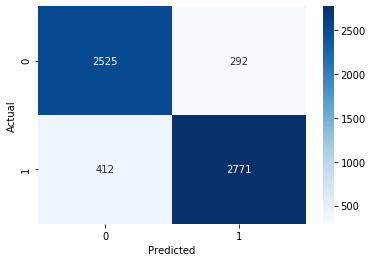

In [112]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
cm = confusion_matrix(prediction, y_test)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [113]:
accuracy_score(prediction, y_test)

0.8826666666666667

In [114]:
f1_score(prediction, y_test)

0.8872878642331092

Text(0.5, 1.0, 'Training of LSTM')

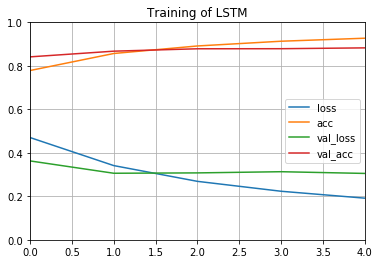

In [117]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.ylim(0,1)
plt.title("Training of LSTM")